# Colour in Eclipsing Binaries in Kepler

The Kepler PSF is *slightly* colour dependent. Due to chromatic aberration, the PSF will be slightly different for a blue star than for a red star. However, the PSF also varies greatly across the focal plane and from target to target due to the flat-field of the instrument.

We can use Eclipsing Binaries to look for changes in the PSF due to colour in Kepler.

### Find a 'model' for the EB

Using the PDCSAP flux from the Kepler pipeline, we will fold and bin the light curve to create a 'model' of the EB. 

### Create light curves of each PIXEL in the TPF

We will create a light curve of each pixel. We will use the out of eclipse data to find and remove any long term trends. We will fold these light curves at the correct period.

### Use model to find eclipse depth in each pixel

Using the PDCSAP flux model, we will fit the PRIMARY and SECONDARY eclipse depths. This will provide a measurement of eclipse depth per pixel, with errors. 

In [1]:
import numpy as np
from lightkurve import KeplerLightCurveFile, KeplerTargetPixelFile, KeplerLightCurve
import pandas as pd
import warnings
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
from scipy.signal import medfilt, savgol_filter
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy import optimize
df = pd.read_csv('prsa.csv')
df = df[df.Morph<0.65].reset_index(drop=True)

In [2]:
def fit_leastsq(init, datax, datay, function):

    errfunc = lambda p, x, y: function(p) - y

    pfit, pcov, infodict, errmsg, success = \
        optimize.leastsq(errfunc, init, args=(datax, datay), \
                          full_output=1, epsfcn=0.0001)

    if (len(datay) > len(init)) and pcov is not None:
        s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(init))
        pcov = pcov * s_sq
    else:
        pcov = np.inf

    error = [] 
    for i in range(len(pfit)):
        try:
            error.append(np.absolute(pcov[i][i])**0.5)
        except:
            error.append( 0.00 )
    pfit_leastsq = pfit
    perr_leastsq = np.array(error) 
    return pfit_leastsq, perr_leastsq 

I have an EB catalog from [here](http://keplerebs.villanova.edu/) which has the periods of the Eclipsing Binaries in Kepler. We'll use this period to fold the eclipsing binary light curves.

Below I download the data for a particular EB and convert the time from BKJD to JD. I also remove any non-finite values

In [63]:
idx = 45
kic, period = df.loc[idx, ['KIC', 'Per']]
lcf = KeplerLightCurveFile.from_archive(kic, quarter=4)
lc = lcf.PDCSAP_FLUX
timejd = lcf.timeobj.jd
lc.time = timejd
tpf = KeplerTargetPixelFile.from_archive(kic, quarter=4)
rawflux = tpf.flux
fin = np.isfinite(lc.flux)
lc = lc[fin]
rawflux = rawflux[fin, :, :]
timejd = timejd[fin]

INFO: Found cached file ./mastDownload/Kepler/kplr007938870_lc_Q111111111111111111/kplr007938870-2010078095331_llc.fits with expected size 469440. [astroquery.query]
INFO: Found cached file ./mastDownload/Kepler/kplr007938870_lc_Q111111111111111111/kplr007938870-2010078095331_lpd-targ.fits.gz with expected size 4546327. [astroquery.query]


Below I fold the light curve at the period given in the catalog and bin down to reduce the noise. I am going to use this folded, binned light curve as a model for the eclipsing binary. I've split these into two halves, one for primary and one for secondary.

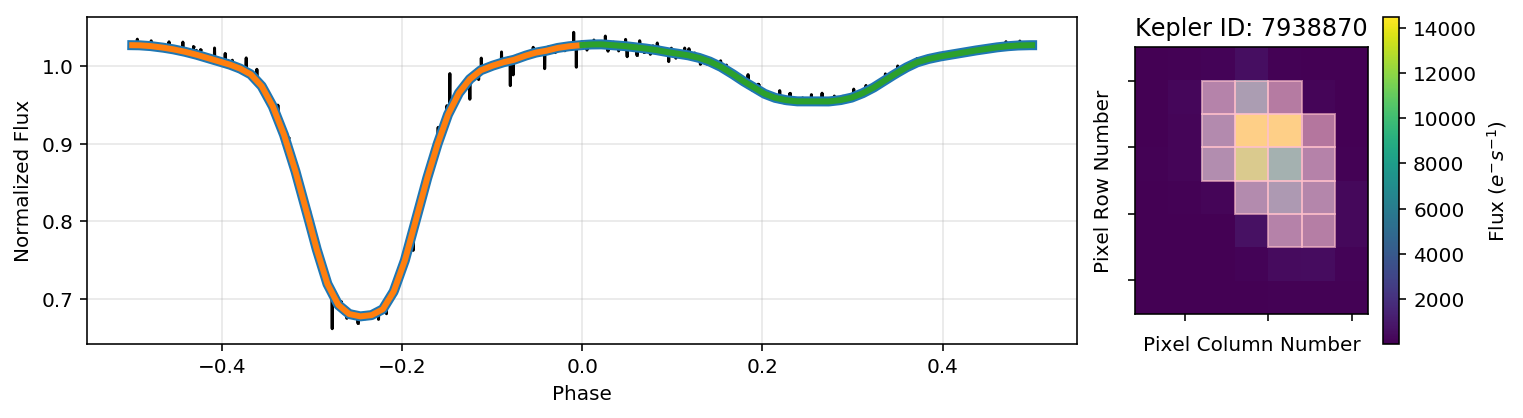

In [64]:
nbins = np.min([int(((lc.time[-1] - lc.time[0])/period)//2), 50])
fold = lc.remove_nans().normalize().fold(period).bin(nbins)
phase = np.nanmedian(fold.time[fold.flux < np.nanpercentile(fold.flux, 1)]) + 0.25
fold = lc.remove_nans().normalize().fold(period, phase).bin(nbins)
model = np.interp(lc.fold(period, phase).time, fold.time, fold.flux)
fold = lc.fold(period, phase)
model_x = fold.time

modela = model[model_x < 0]
modela_x = model_x[model_x < 0]
modelb = model[model_x >= 0]
modelb_x = model_x[model_x >= 0]


primary_depth, px = np.nanmin(model[model_x < 0]), model_x[model_x < 0][np.nanargmin(model[model_x < 0])]
secondary_depth, sx = np.nanmin(model[model_x > 0]),model_x[model_x > 0][np.nanargmin(model[model_x > 0])]
ph = ((lc.time - phase * period) / period) % 1
ph[ph > 0.5] -= 1
not_p = (ph < px - 0.1) | (ph > (px + 0.1))
not_s = (ph < sx - 0.1) | (ph > (sx + 0.1))


# Plot
fig = plt.figure(figsize=(12,3))
ax = plt.subplot2grid((1,4), (0,3))
tpf.plot(ax=ax, aperture_mask=tpf.pipeline_mask)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax = plt.subplot2grid((1,4), (0,0), colspan=3)
fold.plot(ax=ax)
ax.plot(model_x, model, lw=5, zorder=10)
ax.plot(modela_x, modela, lw=3, zorder=10)
ax.plot(modelb_x, modelb, lw=3, zorder=10)

Below is the flux per pixel. There is a significant long term trend in each pixel. We will remove this by taking the out of eclipse data, smoothing and interpolating.

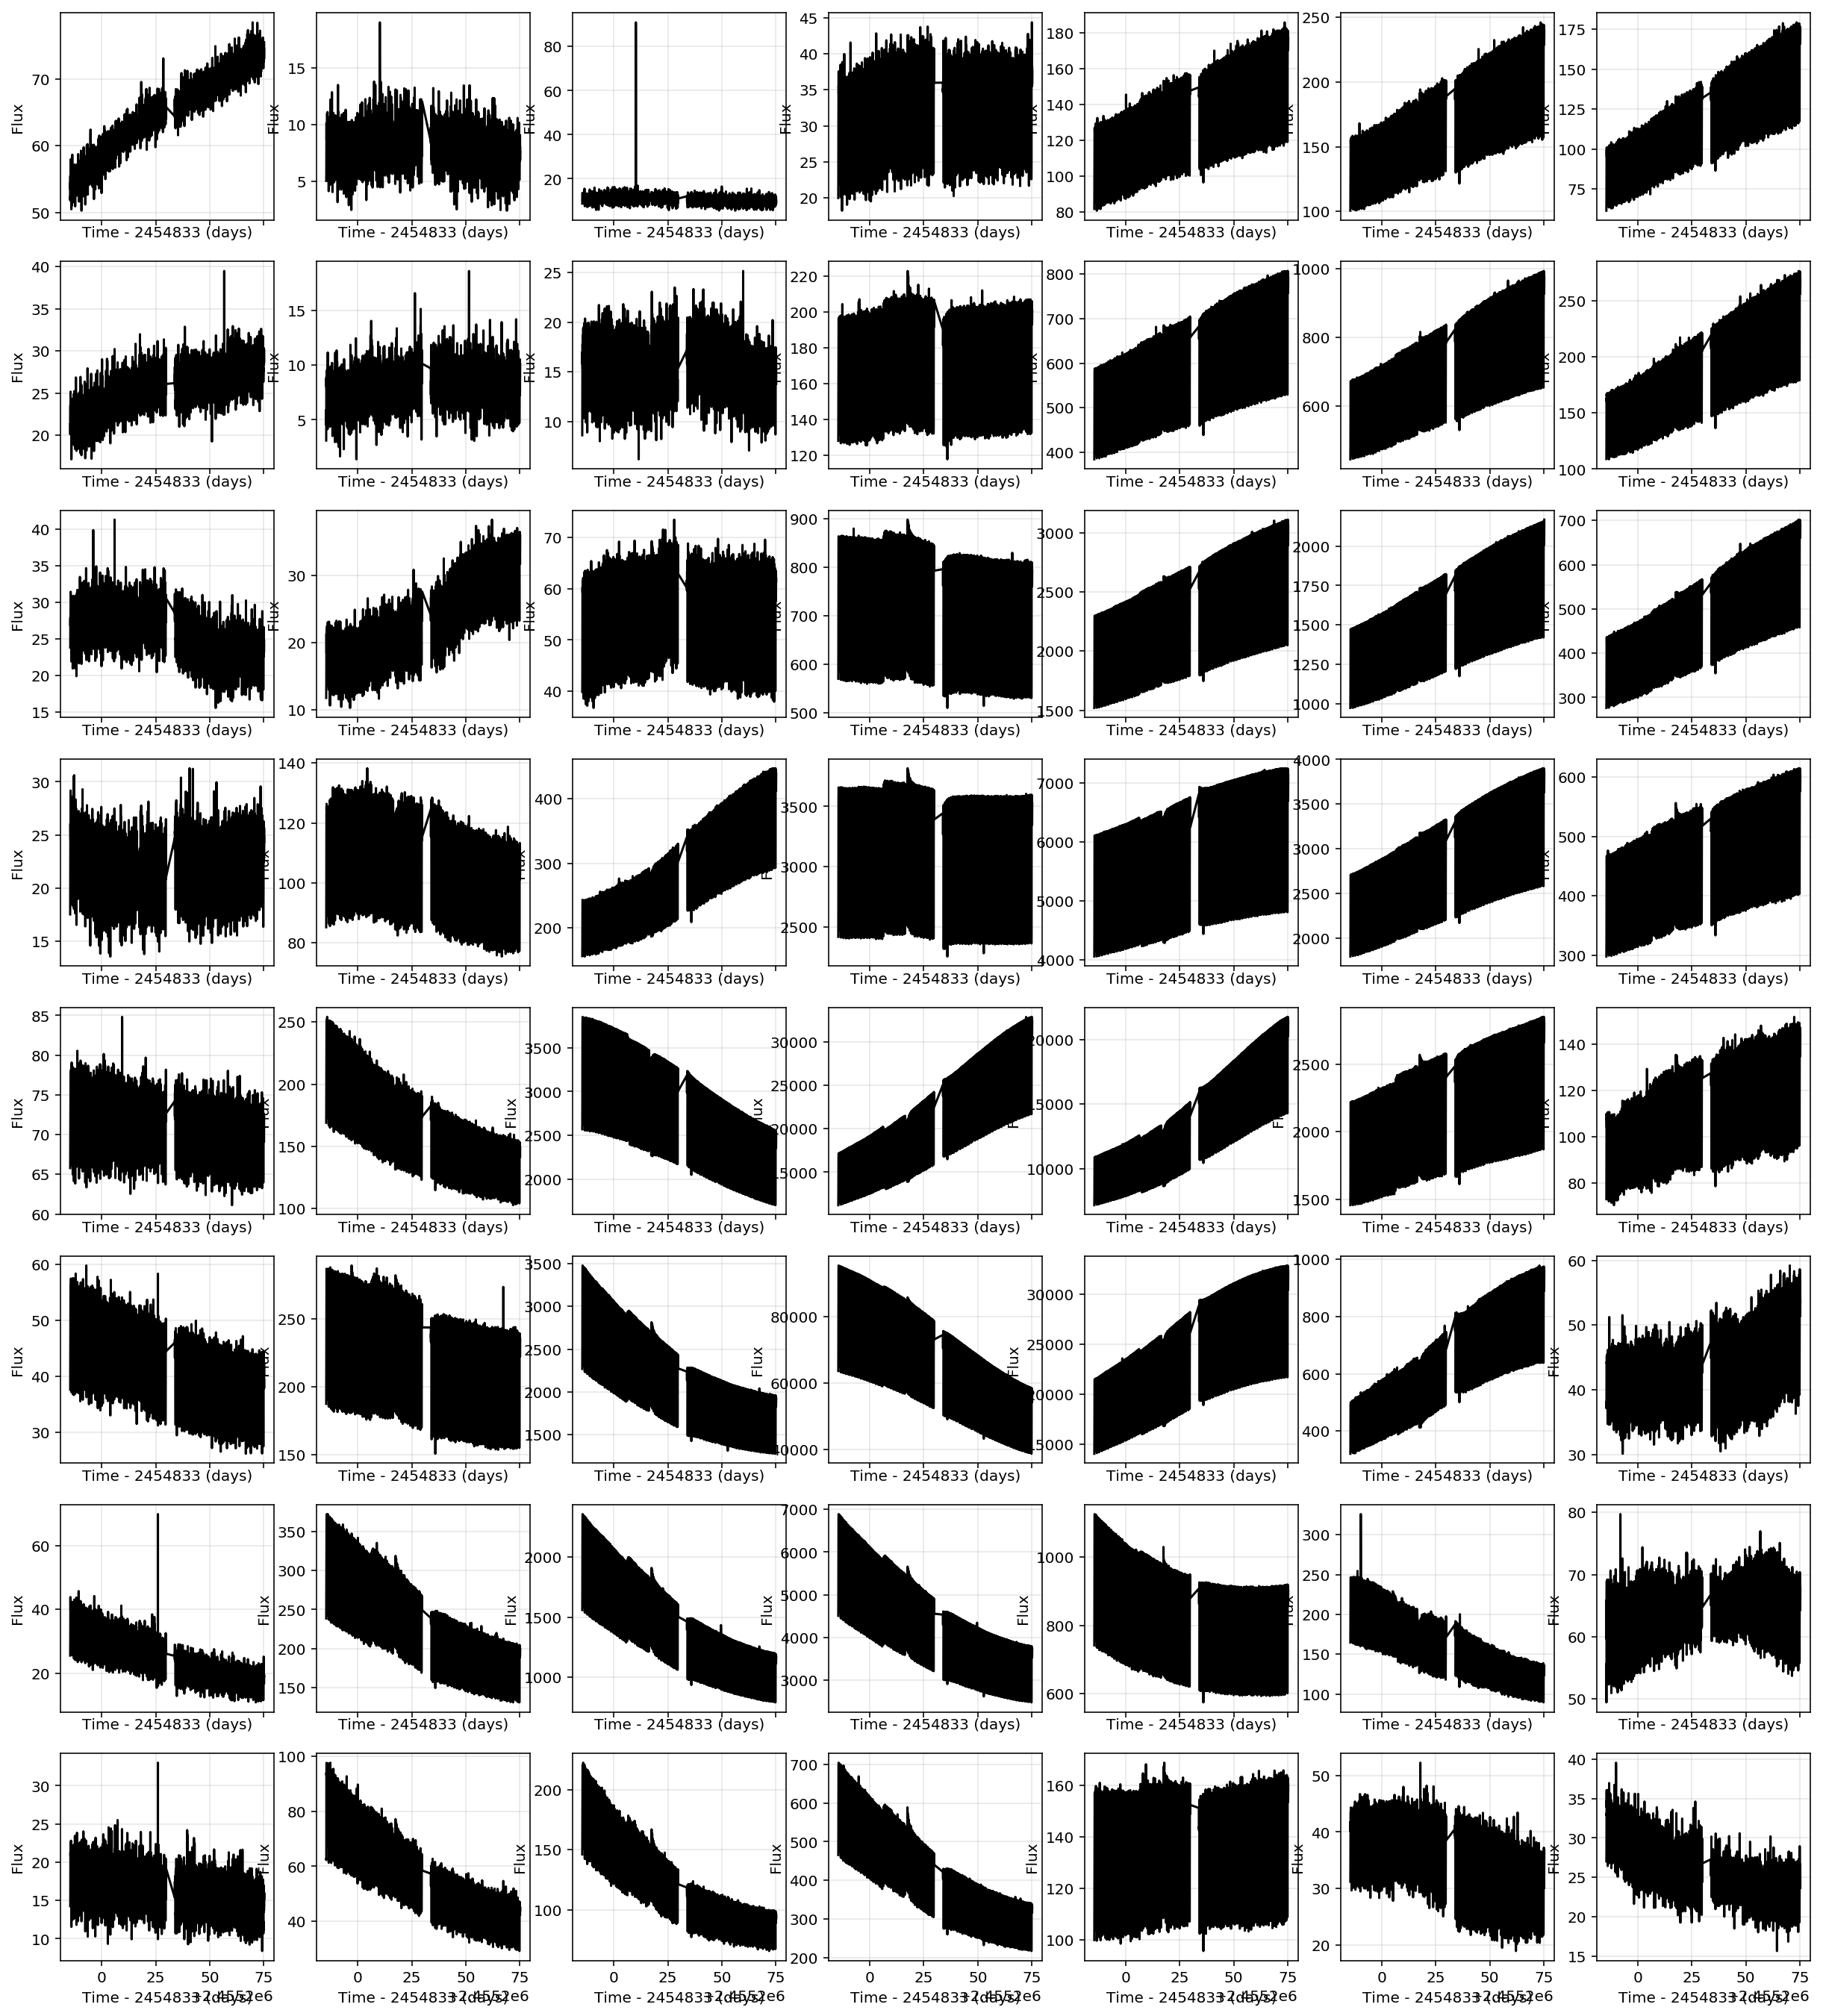

In [65]:
fig, ax = plt.subplots(rawflux.shape[1], rawflux.shape[2], figsize=(3*rawflux.shape[2], 3*rawflux.shape[1]), sharex=True)
for i in range(rawflux.shape[1]):
    for j in range(rawflux.shape[2]):
        l = KeplerLightCurve(timejd, rawflux[:,i,j])
        l.plot(normalize=False, ax=ax[i,j])            

In [66]:
flux = np.copy(rawflux)
for i in range(flux.shape[1]):
    for j in range(flux.shape[2]):
        l = KeplerLightCurve(timejd, flux[:,i,j])
        fin = np.isfinite(l.flux)
        if not np.any(fin):
            continue
        sm = savgol_filter(l[not_s & not_p & fin].flux, 101, 1)
        f = interp1d(l[not_s & not_p & fin].time[101:-101], sm[101:-101], fill_value='extrapolate')
        trend = f(l.time)
        flux[:,i,j] /= trend

The cleaned version is below.

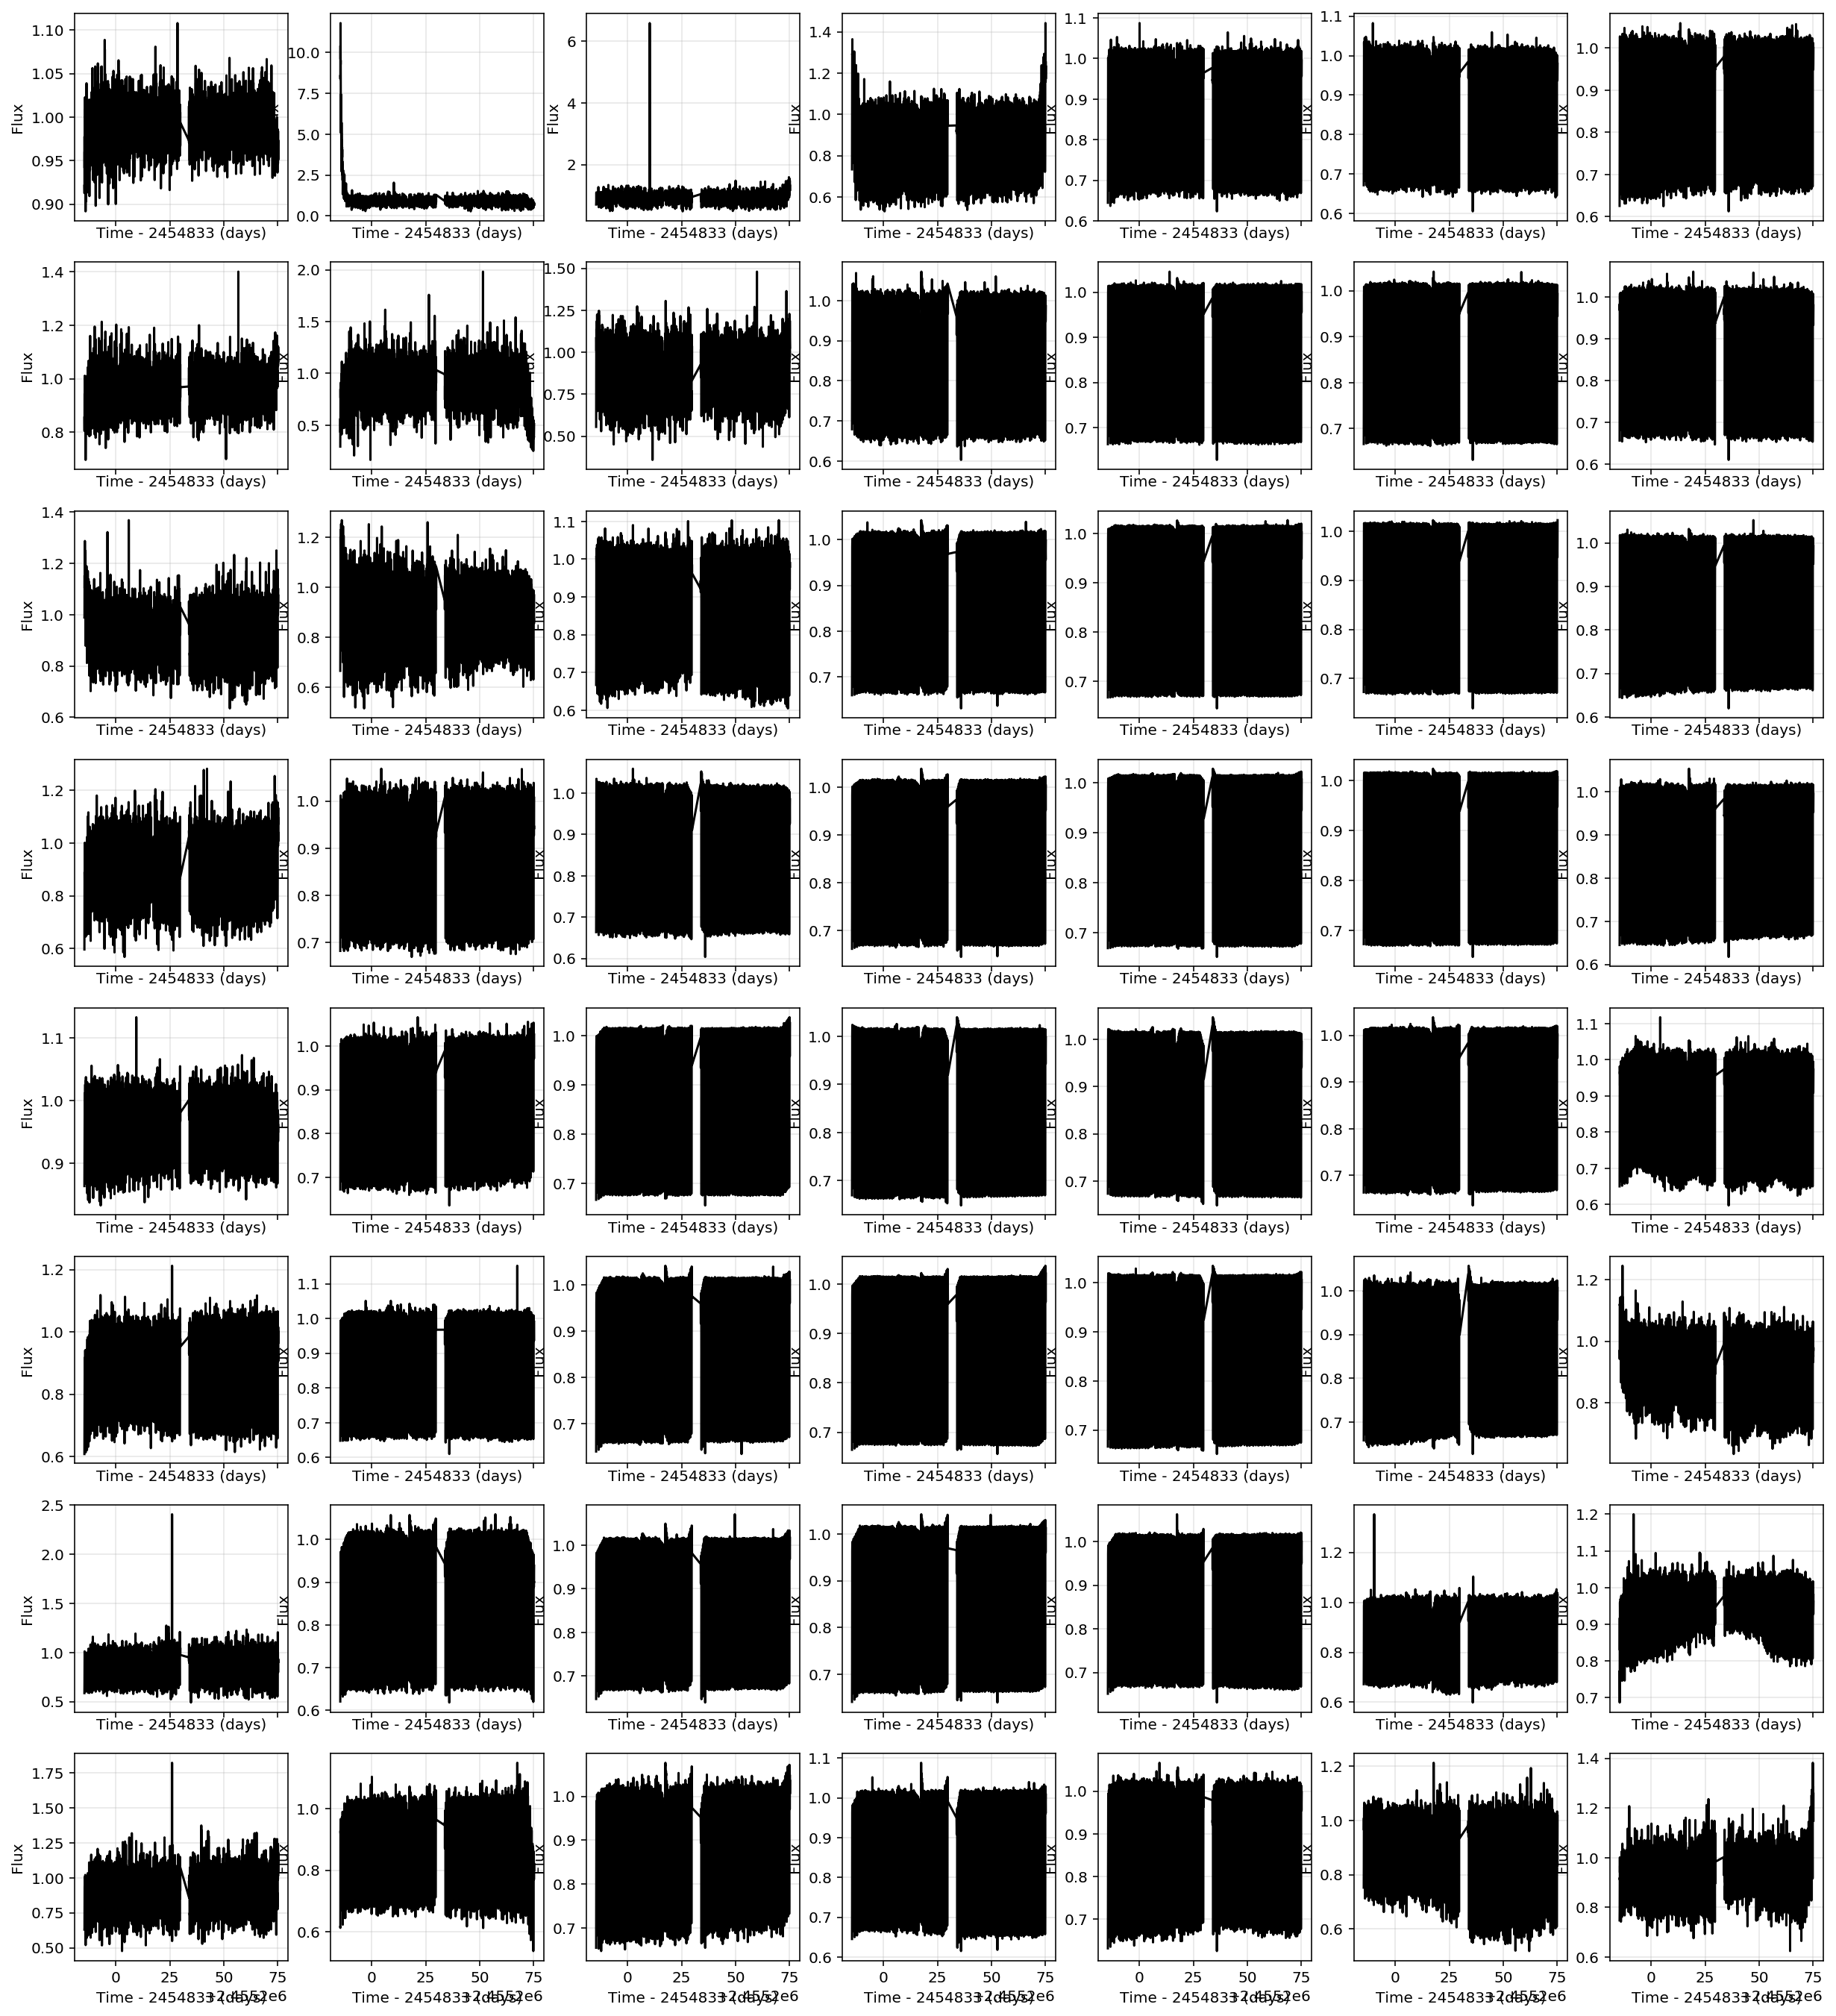

In [67]:
fig, ax = plt.subplots(flux.shape[1], flux.shape[2], figsize=(3*flux.shape[2], 3*flux.shape[1]), sharex=True)
for i in range(flux.shape[1]):
    for j in range(flux.shape[2]):
        l = KeplerLightCurve(timejd, flux[:,i,j])
        l.plot(normalize=False, ax=ax[i,j])            

Now that the light curves are clean, we can fold each one and fit both the PRIMARY and SECONDARY model. We do this with a simple least squares fit, which will give us the errors on the fit parameter.

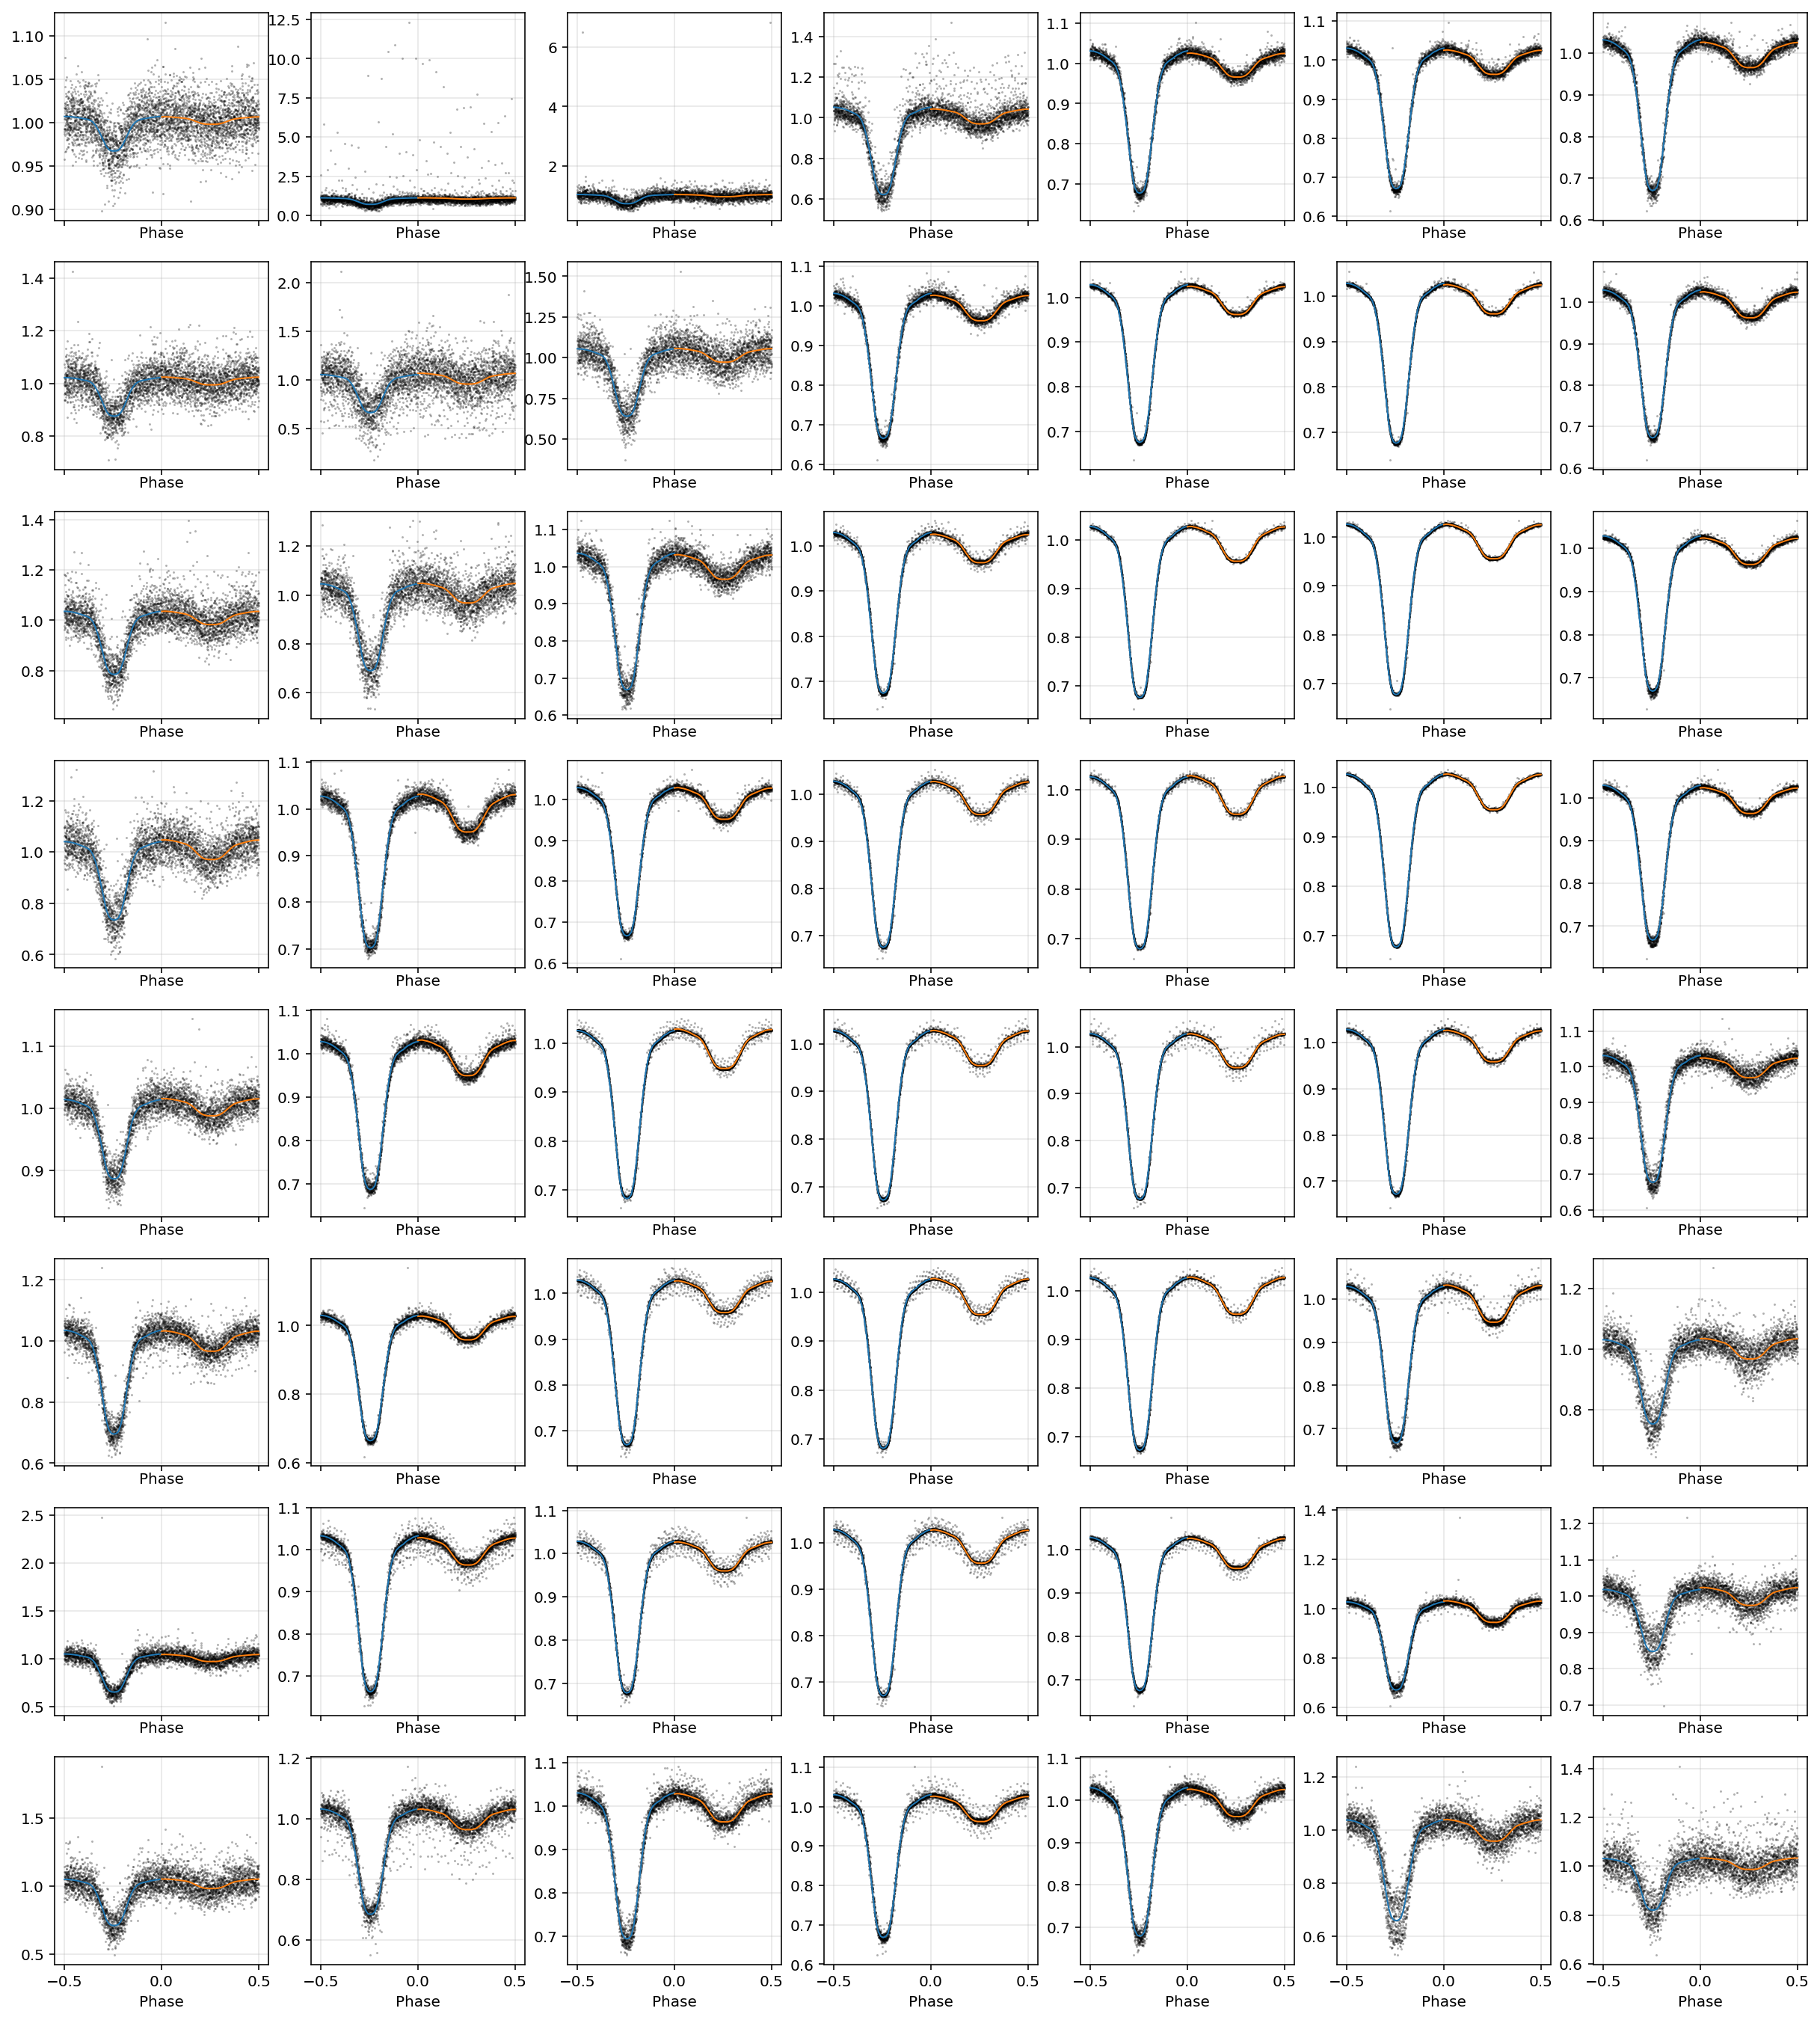

In [68]:
fig, ax = plt.subplots(flux.shape[1], flux.shape[2], figsize=(3*flux.shape[2], 3*flux.shape[1]), sharex=True)
depths = np.zeros((2, flux.shape[1], flux.shape[2]))*np.nan
depths_err = np.zeros((2, flux.shape[1], flux.shape[2]))*np.nan
for i in range(flux.shape[1]):
    for j in range(flux.shape[2]):
        l = KeplerLightCurve(timejd, flux[:,i,j])
        #l.plot(ax=ax[i,j])            
        #continue
        
        if np.nansum(l.flux) == 0:
            ax[i,j].set_facecolor('grey')
            depths[:, i, j] *= np.nan
            continue
        fold = l.normalize().fold(period, phase)
        fold.plot(ax = ax[i,j], marker='.', linestyle='', markersize=1, alpha=0.3)
#        ax[i,j].plot(model_x, model, lw=2, zorder=10)
        ax[i,j].set_ylabel('')
        
        oks  = [(fold.time < 0), fold.time > 0]
        ms = [modela, modelb]
        for idx, ok, m in zip([0,1], oks, ms):
            def func(params):
                fl = (params[0] * m) - params[0] + params[1]
                return fl
            pfit, perr = fit_leastsq([1,1], fold.time[ok], fold.flux[ok], func)
            ax[i,j].plot(fold.time[ok], func(pfit), lw=1)
            ax[i,j].fill_between(fold.time[ok], func([pfit[0]-perr[0], pfit[1]]), func([pfit[0]+perr[0], pfit[1]]), alpha=0.5)
            depths[idx, i, j] = pfit[0]
            depths_err[idx, i, j] = perr[0]

We can see there is a good fit in all pixels. We have retrieved a scaling parameter $n$ for each pixel:

$d' = n * d + c$

Where $d'$ is the new depth, $d$ is the depth in the PDCSAP light curve and $c$ is some offset.

Let's take a look at that scaling factor across all pixels for the PRIMARY and SECONDARY eclipse.

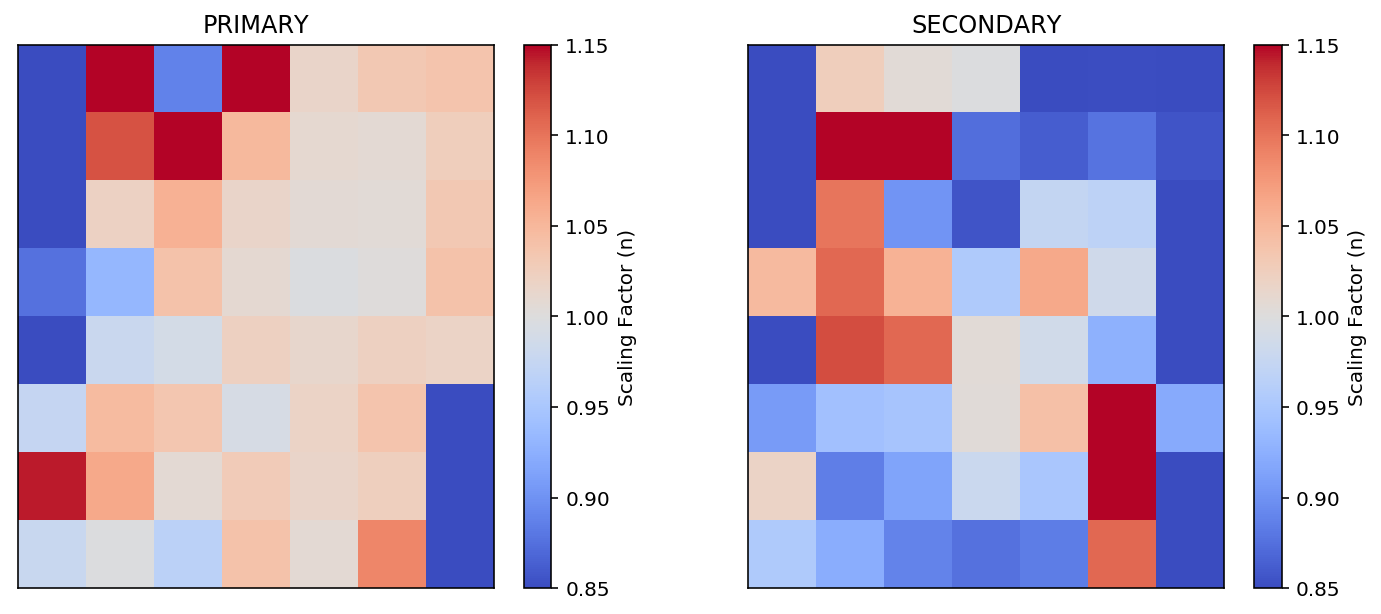

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
im = ax[0].imshow(depths[0], vmin=0.85, vmax=1.15, cmap=plt.get_cmap('coolwarm'))
cbar = plt.colorbar(im, ax=ax[0])
cbar.set_label('Scaling Factor (n)')
ax[0].set_title('PRIMARY')
ax[0].set_xticks([])
ax[0].set_yticks([])


im = ax[1].imshow(depths[1], vmin=0.85, vmax=1.15, cmap=plt.get_cmap('coolwarm'))
cbar = plt.colorbar(im, ax=ax[1])
cbar.set_label('Scaling Factor (n)')
ax[1].set_title('SECONDARY')
ax[1].set_xticks([])
ax[1].set_yticks([]);

If there is no change in PSF shape during these two events, these images should be identical. In this case, we see they are not.

Some of these pixels are not useful for our characterisation. Particularly where they have large errors, so let's cut those out.

In [70]:
err = (depths_err[1]**2 + depths_err[0]**2)**0.5
aper = np.all(np.abs(depths - 1) < 0.5, axis=0).astype(float)
aper[aper==0] = np.nan
aper[err > 0.1] = np.nan

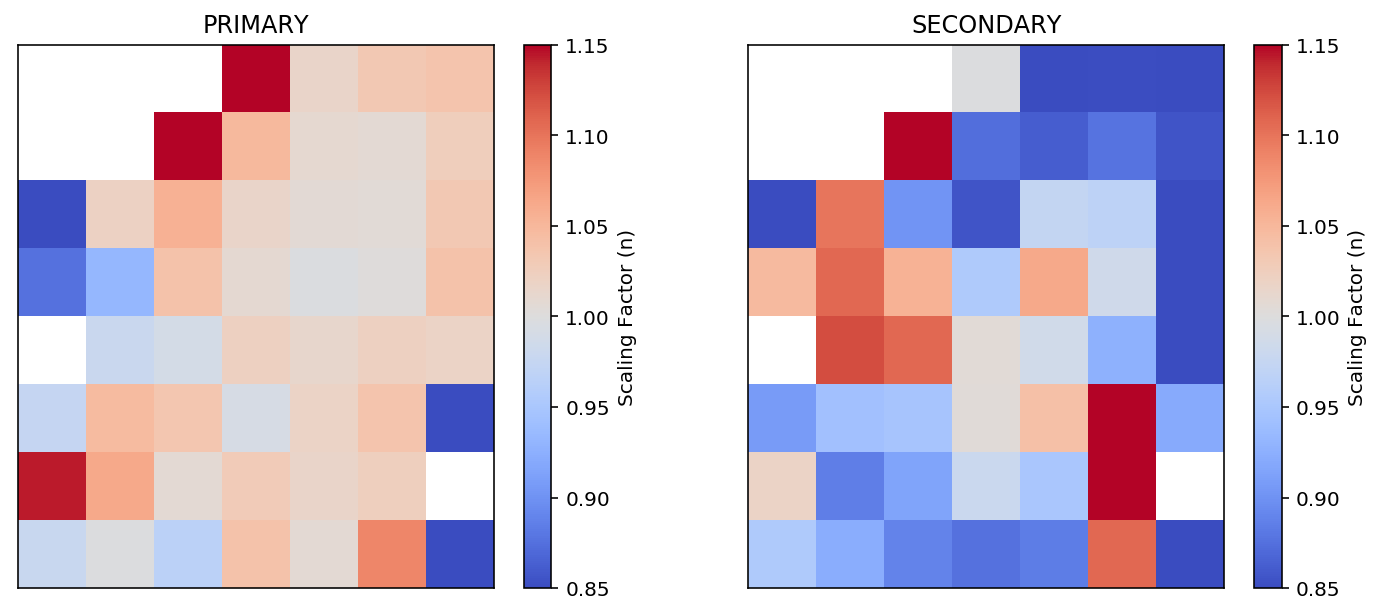

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
im = ax[0].imshow(depths[0]*aper, vmin=0.85, vmax=1.15, cmap=plt.get_cmap('coolwarm'))
cbar = plt.colorbar(im, ax=ax[0])
cbar.set_label('Scaling Factor (n)')
ax[0].set_title('PRIMARY')
ax[0].set_xticks([])
ax[0].set_yticks([])


im = ax[1].imshow(depths[1]*aper, vmin=0.85, vmax=1.15, cmap=plt.get_cmap('coolwarm'))
cbar = plt.colorbar(im, ax=ax[1])
cbar.set_label('Scaling Factor (n)')
ax[1].set_title('SECONDARY')
ax[1].set_xticks([])
ax[1].set_yticks([]);

Let's plot the depth in each pixel for primary and secondary eclipse, with errors. We can see that they are not perfectly correlated, there is structure in the above image.

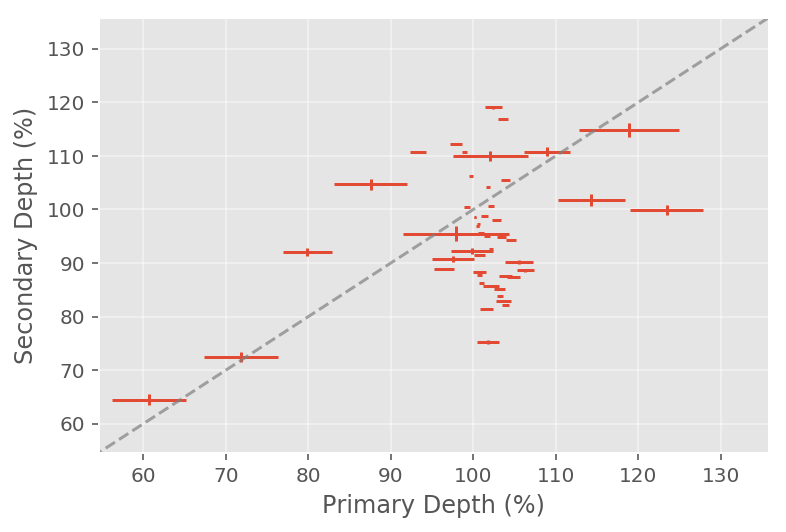

In [72]:
with plt.style.context(('ggplot')):
    ax = plt.subplot(111)
    ax.errorbar(100.*(depths[0]*aper).ravel(), 100.*(depths[1]*aper).ravel(),
                 yerr=100.*(depths_err[0]*aper).ravel(), xerr=100.*(depths_err[1]*aper).ravel(), ls='')
    ax.set_ylabel('Secondary Depth (%)')
    ax.set_xlabel('Primary Depth (%)')
    ax.plot([0,200],[0,200], ls='--', color='gray', alpha=0.7)
    ax.set_xlim(0.9*np.nanmin(depths*np.atleast_2d(aper))*100, 1.1*np.nanmax(depths*np.atleast_2d(aper))*100)
    ax.set_ylim(0.9*np.nanmin(depths*np.atleast_2d(aper))*100, 1.1*np.nanmax(depths*np.atleast_2d(aper))*100)
    ax.grid(alpha=0.5)

This suggests that there is a significant shape change in the PSF between primary and secondary for at least some EBs